In [2]:
# Data processing and visualization libs
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from collections import Counter

# Web scraping libs
import time
import requests
from bs4 import BeautifulSoup
import re

## Part I: Data Gathering

In [2]:
def get_chart(trend_df, change_df, title_df, chart_dates, root_url):
    # Generate all chart url links
    full_url = [root_url + date for date in chart_dates]
    for i in range(len(full_url)):
        root_html = requests.get(full_url[i])
        root_bs = BeautifulSoup(root_html.text, 'html.parser')
        # Get the exact chart number of each song
        chart_index = [int(n.get_text()) - 1 for n in root_bs.find_all(class_ = 'chart-element__rank__number')]
        if len(chart_index) == 100:
            trend = pd.Series([t.get_text() for t in root_bs.find_all(class_ = re.compile('^chart-element__trend chart-element__trend'))], index = range(100))
            change = pd.Series([c.get_text() for c in root_bs.find_all(class_ = 'chart-element__information__delta__text text--default')], index = range(100))
            title = pd.Series([t.get_text() for t in root_bs.find_all(class_ = 'chart-element__information__song text--truncate color--primary')], index = range(100))
            artist = pd.Series([a.get_text() for a in root_bs.find_all(class_ = 'chart-element__information__artist text--truncate color--secondary')], index = range(100))
            trend_df[chart_dates[i]] = trend
            change_df[chart_dates[i]] = change
            title_df[chart_dates[i]] = title + [' - ']*100 + artist
            print('{w} is finished with {n} entries.'.format(w = chart_dates[i], n = [len(trend), len(change), len(title)]))
            time.sleep(5)
        elif (len(chart_index) < 100) & (len(chart_index) > 90):
            # Remove possible dulplicated chart numbers (I suppose the ranking method is: 1, 2 ,3, 3, 5 instead of 1, 2, 3, 3, 4)
            chart_index = [chart_index[0]] + [m + 1 if m == n else m for n, m in zip(chart_index[:-1], chart_index[1:])]
            trend = pd.Series([t.get_text() for t in root_bs.find_all(class_ = re.compile('^chart-element__trend chart-element__trend'))], index = chart_index)
            change = pd.Series([c.get_text() for c in root_bs.find_all(class_ = 'chart-element__information__delta__text text--default')], index = chart_index)
            title = pd.Series([t.get_text() for t in root_bs.find_all(class_ = 'chart-element__information__song text--truncate color--primary')], index = chart_index)
            artist = pd.Series([a.get_text() for a in root_bs.find_all(class_ = 'chart-element__information__artist text--truncate color--secondary')], index = chart_index)
            trend_df[chart_dates[i]] = trend
            change_df[chart_dates[i]] = change
            title_df[chart_dates[i]] = title + [' - ']*len(chart_index) + artist
            print('{w} is finished with {n} entries.'.format(w = chart_dates[i], n = [len(trend), len(change), len(title)]))
            time.sleep(5)
        else:
            trend_df[chart_dates[i]] = np.nan
            change_df[chart_dates[i]] = np.nan
            title_df[chart_dates[i]] = np.nan
            print('[Warning] {w} has {n} entries.'.format(w = chart_dates[i], n = [len(chart_index)]))

In [3]:
# Generate all the chart dates in HOT 100 history.
# The earliest available date is 1958-08-04 and the second earliest date is 1958-08-09. After that, the chart updates weekly regularly.  
chart_dates = list(pd.date_range(start = '1958-08-02', end = '2020-02-01', freq='7d').astype('str'))
root_url = 'https://www.billboard.com/charts/hot-100/'

# trend_df = pd.DataFrame(index = range(100))
# change_df = pd.DataFrame(index = range(100))
# title_df = pd.DataFrame(index = range(100))

trend_df = pd.read_csv('trend_df.csv')
change_df = pd.read_csv('change_df.csv')
title_df = pd.read_csv('title_df.csv')

# Week 1976-11-27 missed No. 45 on chart, Week 1977-01-22 has two No. 18 on chart, Week 1978-08-13 has two No. 66 on chart but the next two numbers are 67, 69
# get_chart(trend_df, change_df, title_df, chart_dates, root_url)

In [22]:
pd.set_option('display.max_columns', 18)

## Part II: The 'New's in Chart

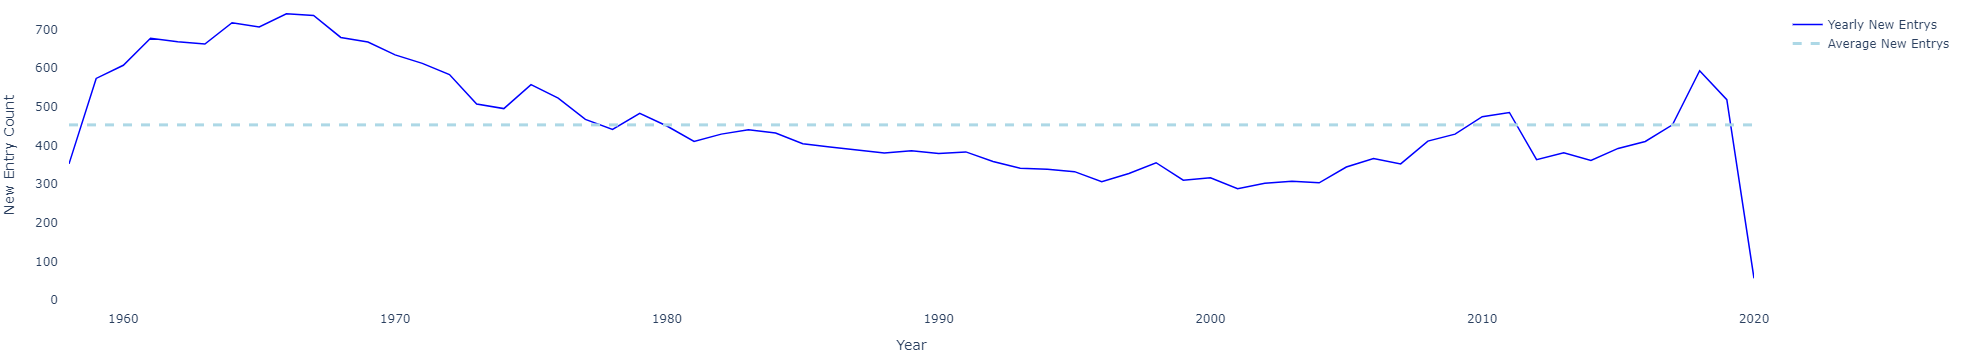

In [37]:
news_all = (trend_df.loc[:, :] == 'New').sum()
news_all.index = [d[:4] for d in news_all.index]
news_all = news_all.groupby(level = 0).sum()
fig = go.Figure()
fig.add_trace(go.Scatter(x=news_all.index,
                         y=news_all,
                         line=dict(color='blue', width=1.5),
                         name='Yearly New Entrys'))
fig.add_trace(go.Scatter(x=news_all.index,
                         y=[round(news_all.mean(), 2)]*len(news_all),
                         line=dict(color='lightblue', width=3, dash='dash'),
                         name='Average New Entrys'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="New Entry Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 750])
fig.show()
fig.write_html("visuals/new_songs_yearly.html")

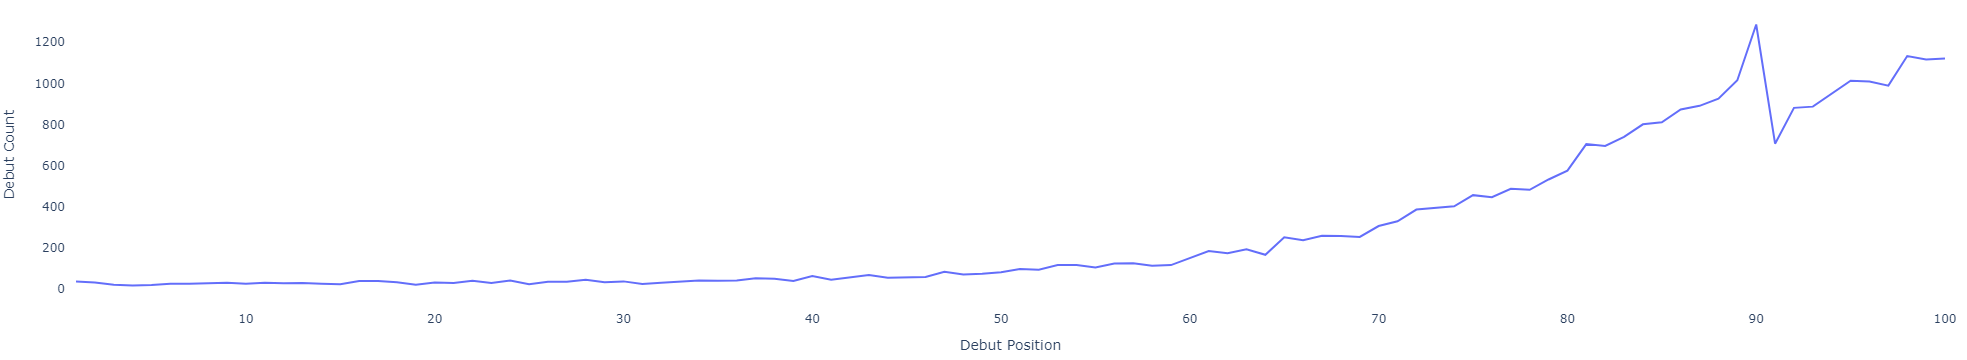

In [5]:
fig = go.Figure(go.Scatter(x=(trend_df == 'New').sum(axis = 1).index + 1,
                           y=(trend_df == 'New').sum(axis = 1),
                           mode='lines',
                           name='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Debut Position",
                  yaxis_title="Debut Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

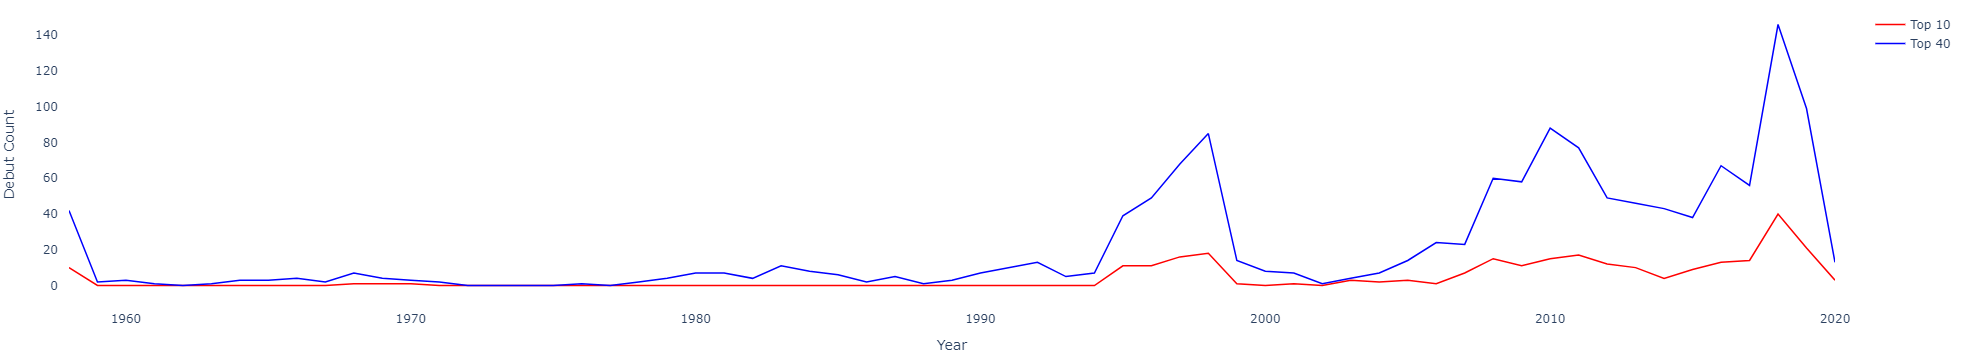

In [137]:
fig = go.Figure()
news_top10 = (trend_df.loc[:9, :] == 'New').sum()
news_top10.index = [d[:4] for d in news_top10.index]
news_top10 = news_top10.groupby(level = 0).sum()
fig.add_trace(go.Scatter(x=news_top10.index,
                         y=news_top10,
                         line=dict(color = 'red', width = 1.5),
                         name='Top 10'))
news_top40 = (trend_df.loc[:39, :] == 'New').sum()
news_top40.index = [d[:4] for d in news_top40.index]
news_top40 = news_top40.groupby(level = 0).sum()
fig.add_trace(go.Scatter(x=news_top40.index,
                         y=news_top40,
                         line=dict(color = 'blue', width = 1.5),
                         name='Top 40'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Debut Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()
fig.write_html("visuals/new_songs_top40.html")

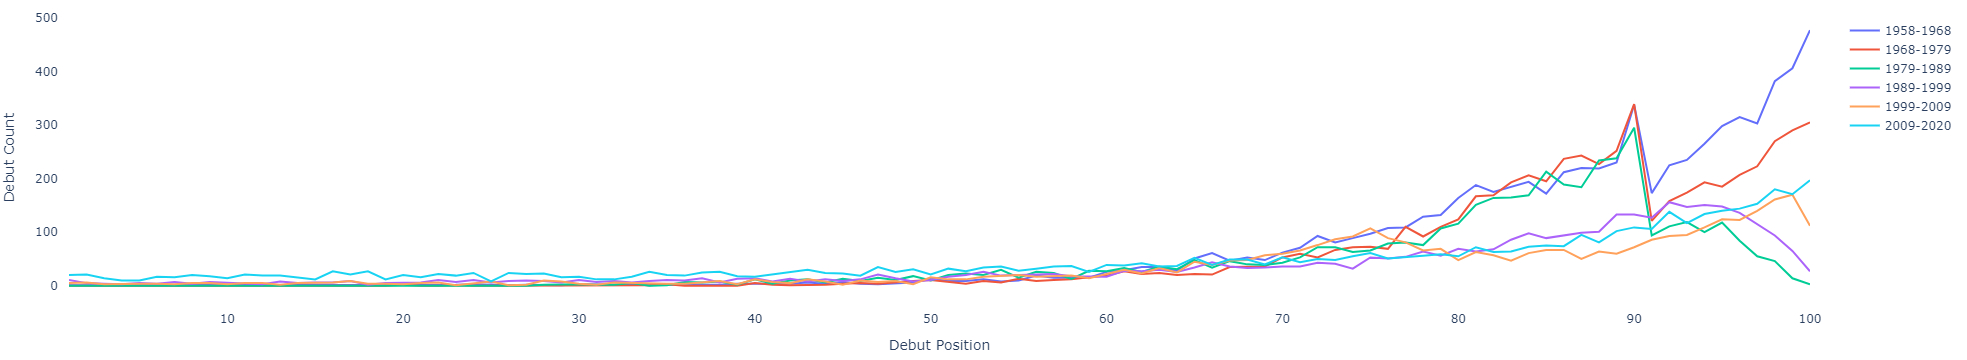

In [62]:
fig = go.Figure()
for i in range(0, len(trend_df.columns), 535):
    fig.add_trace(go.Scatter(x=list(range(1, 101)),
                             y=(trend_df == 'New').iloc[:, i:(i+535)].sum(axis = 1),
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Debut Position",
                  yaxis_title="Debut Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

## Part III: The 'Steady's in Chart

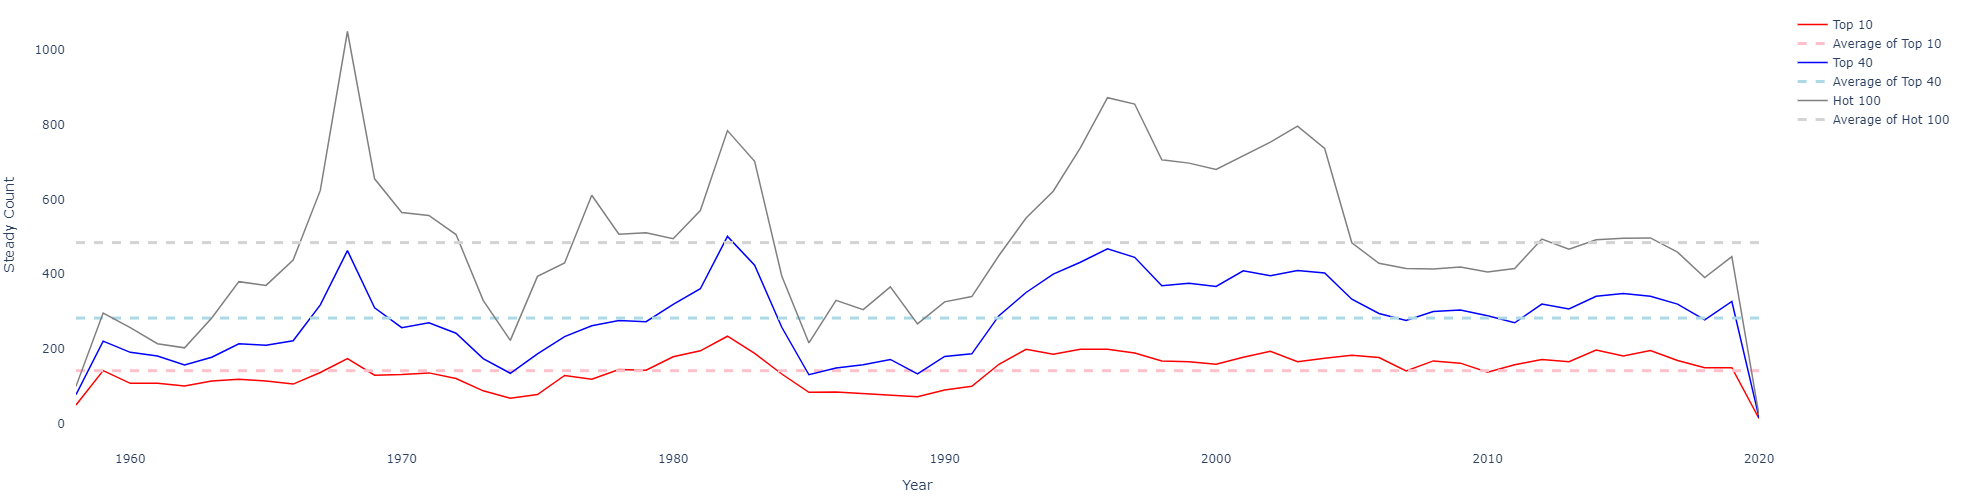

In [47]:
fig = go.Figure()
c1y_li = (trend_df.loc[:9, :] == 'Steady').sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).sum()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color = 'red', width = 1.5),
                         name='Top 10'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color = 'pink', width = 3, dash = 'dash'),
                         name='Average of Top 10'))

c1y_li = (trend_df.loc[:39, :] == 'Steady').sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).sum()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color = 'blue', width = 1.5),
                         name='Top 40'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color = 'lightblue', width = 3, dash = 'dash'),
                         name='Average of Top 40'))

c1y_li = (trend_df.loc[:, :] == 'Steady').sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).sum()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color = 'grey', width = 1.5),
                         name='Hot 100'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color = 'lightgrey', width = 3, dash = 'dash'),
                         name='Average of Hot 100'))

fig.update_layout(width=1000, 
                  height=500, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Steady Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()
fig.write_html("visuals/steady_songs_hot100.html")

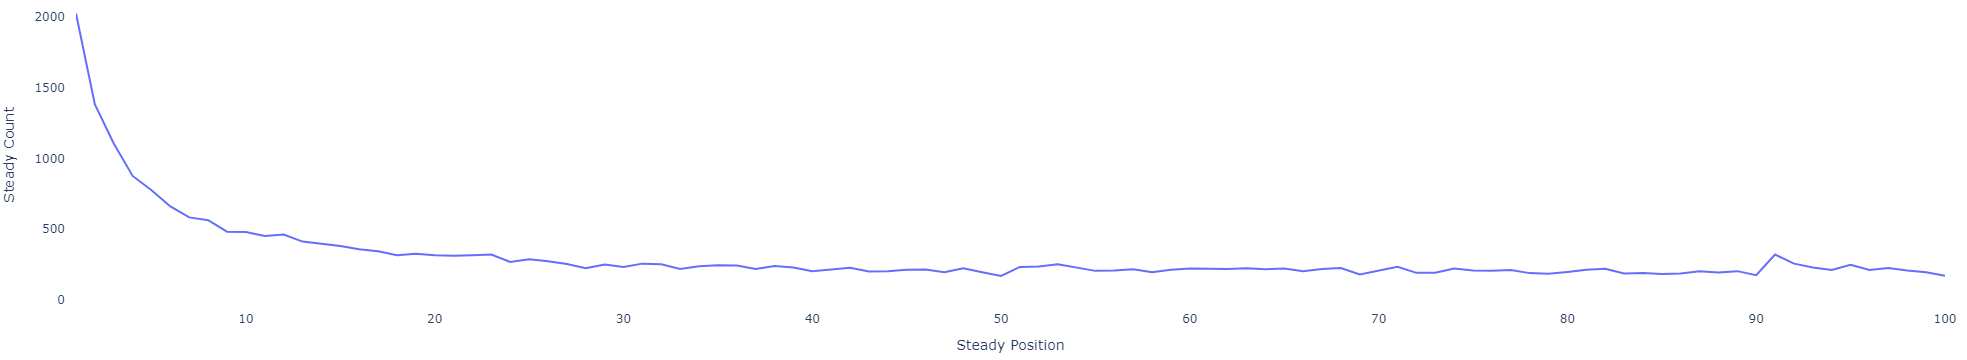

In [64]:
fig = go.Figure(go.Scatter(x=(trend_df == 'Steady').sum(axis = 1).index + 1,
                           y=(trend_df == 'Steady').sum(axis = 1),
                           mode='lines',
                           name='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Steady Position",
                  yaxis_title="Steady Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 2050])
fig.show()

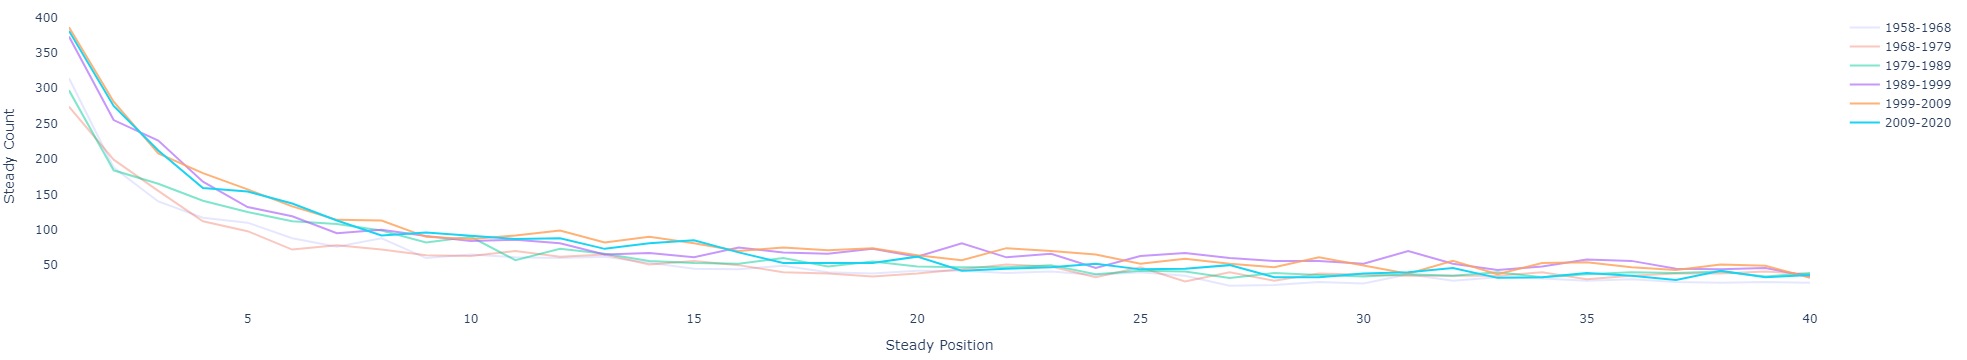

In [67]:
fig = go.Figure()
for i in range(0, len(trend_df.columns), 535):
    fig.add_trace(go.Scatter(x=list(range(1, 101)),
                             y=(trend_df == 'Steady').iloc[0:40, i:(i+535)].sum(axis = 1),
                             mode='lines',
                             opacity=(i+535)/3210,
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Steady Position",
                  yaxis_title="Steady Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()
fig.write_html("visuals/steady_songs_position_decennialy.html")

In [158]:
trend_df.columns[(trend_df == 'Steady').sum() > 40]

Index(['1977-01-01', '1977-12-31', '1978-12-30', '1979-12-29', '1981-01-03',
       '1982-01-02', '1983-01-01', '1983-12-31', '1984-12-29', '1986-01-04',
       '1987-01-03', '1988-01-02', '1988-12-31', '1989-12-30', '1990-12-29',
       '1991-12-28'],
      dtype='object')

## Part IV: The Rises and Falls in Chart

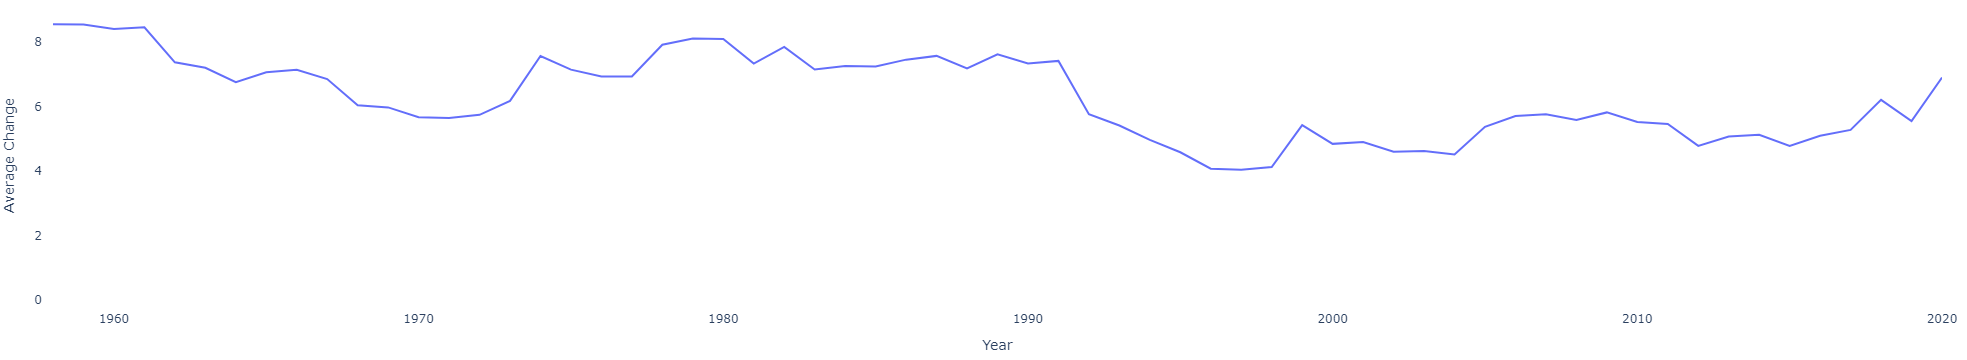

In [67]:
c1y_li = abs(change_df.loc[:, :].replace('-', 0).fillna(0).astype('int')).mean()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig = go.Figure(go.Scatter(x=c1y_li.index,
                           y=c1y_li,
                           mode='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 9])
fig.show()

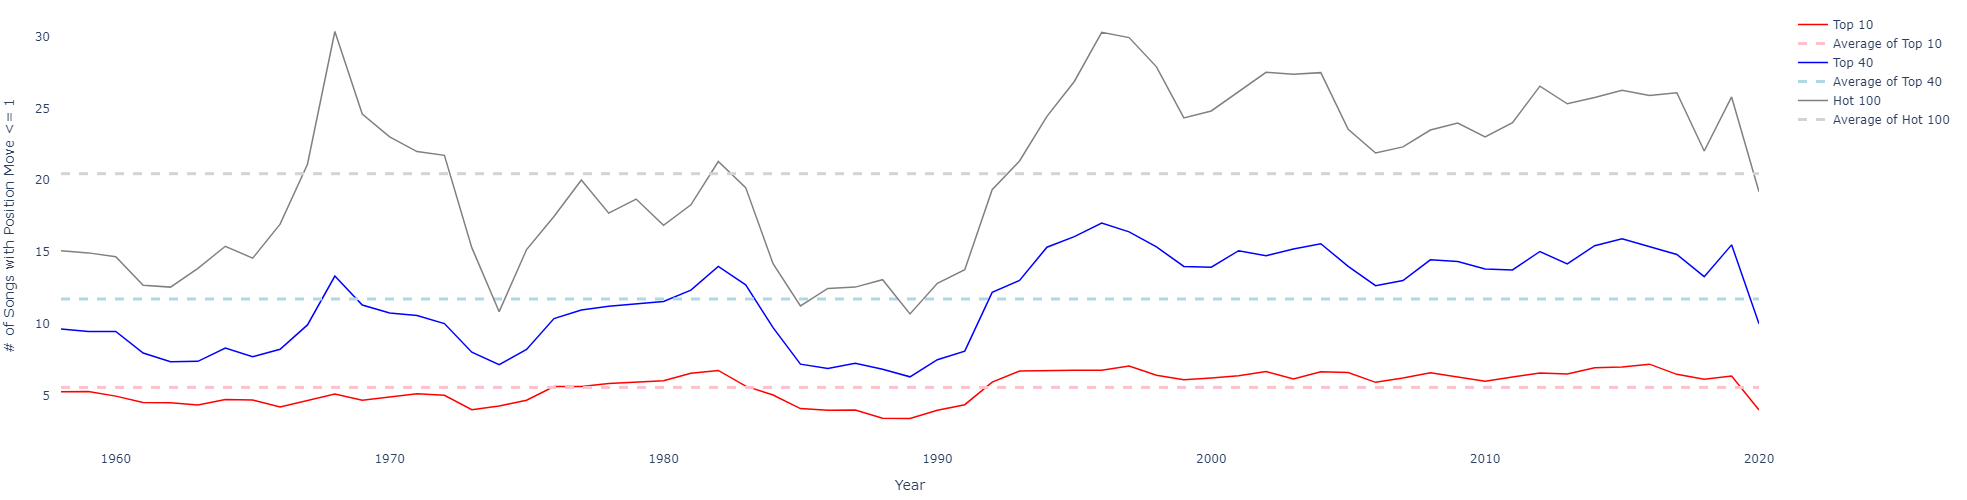

In [59]:
fig = go.Figure()
n = 1

c1y_li = (abs(change_new_df.loc[0:9, :].replace('-', 0).fillna(0).astype('int')) <= n).sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color='red', width=1.5),
                         name='Top 10'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color='pink', width=3, dash='dash'),
                         name='Average of Top 10'))

c1y_li = (abs(change_new_df.loc[0:39, :].replace('-', 0).fillna(0).astype('int')) <= n).sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color='blue', width=1.5),
                         name='Top 40'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color='lightblue', width=3, dash='dash'),
                         name='Average of Top 40'))

c1y_li = (abs(change_new_df.loc[:, :].replace('-', 0).fillna(0).astype('int')) <= n).sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color='grey', width=1.5),
                         name='Hot 100'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color='lightgrey', width=3, dash='dash'),
                         name='Average of Hot 100'))

fig.update_layout(width=1000, 
                  height=500, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="# of Songs with Position Move <= {n}".format(n = n),
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
# fig.update_yaxes(range=[0, 31])
fig.show()

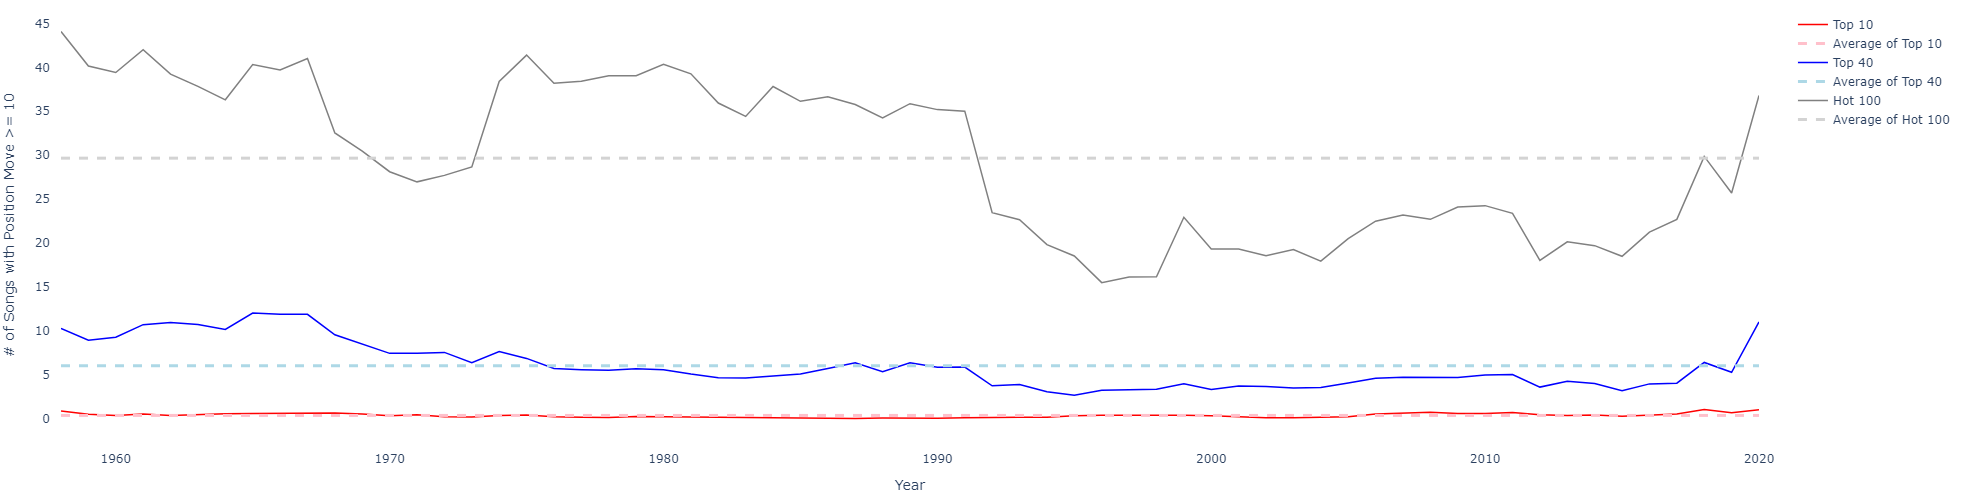

In [58]:
fig = go.Figure()
n = 10

c1y_li = (abs(change_new_df.loc[0:9, :].replace('-', 0).fillna(0).astype('int')) >= n).sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color='red', width=1.5),
                         name='Top 10'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color='pink', width=3, dash='dash'),
                         name='Average of Top 10'))

c1y_li = (abs(change_new_df.loc[0:39, :].replace('-', 0).fillna(0).astype('int')) >= n).sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color='blue', width=1.5),
                         name='Top 40'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color='lightblue', width=3, dash='dash'),
                         name='Average of Top 40'))

c1y_li = (abs(change_new_df.loc[:, :].replace('-', 0).fillna(0).astype('int')) >= n).sum()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color='grey', width=1.5),
                         name='Hot 100'))
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=[round(c1y_li.mean(),2)]*len(c1y_li),
                         line=dict(color='lightgrey', width=3, dash='dash'),
                         name='Average of Hot 100'))

fig.update_layout(width=1000, 
                  height=500, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="# of Songs with Position Move >= {n}".format(n = n),
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
# fig.update_yaxes(range=[0, 31])
fig.show()

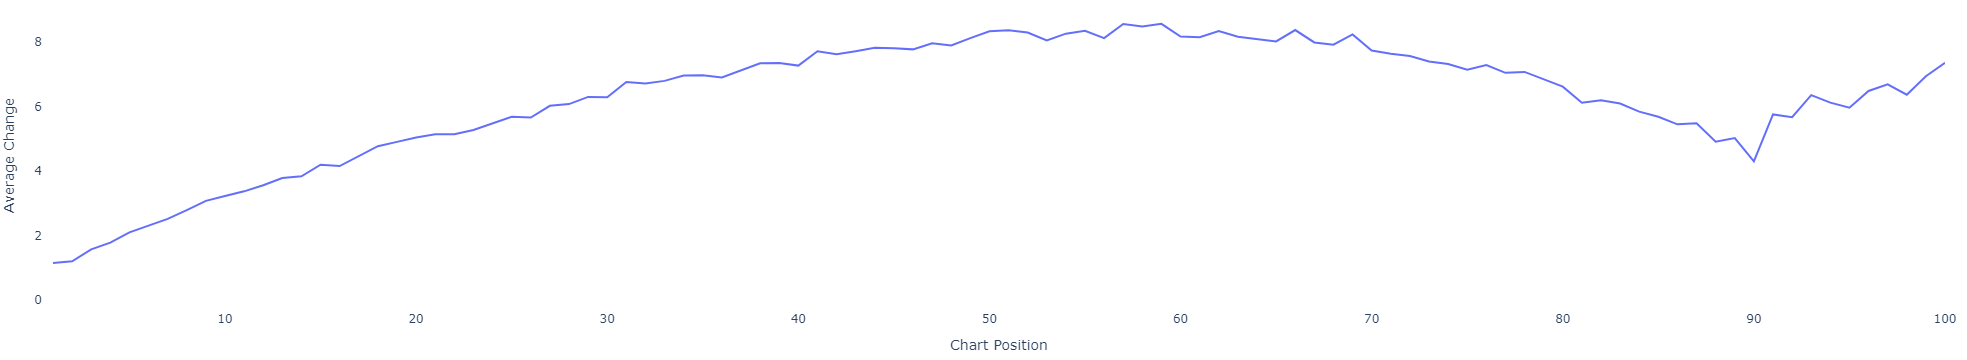

In [68]:
c1y_li = abs(change_df.loc[:, :].replace('-', 0).fillna(0).astype('int')).mean(axis = 1)
fig = go.Figure(go.Scatter(x=list(range(1, 101)),
                           y=c1y_li,
                           mode='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Chart Position",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 9])
fig.show()

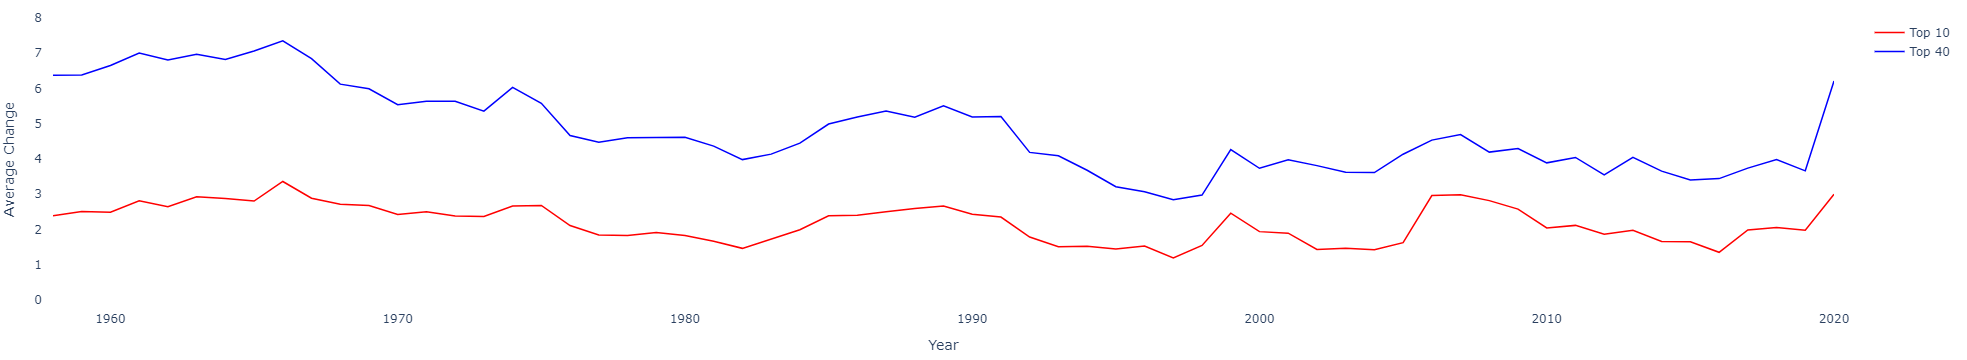

In [135]:
fig = go.Figure()

c1y_li = abs(change_df.loc[:9, :].replace('-', 0).fillna(0).astype('int')).mean()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color = 'red', width = 1.5),
                         name='Top 10'))

c1y_li = abs(change_df.loc[:39, :].replace('-', 0).fillna(0).astype('int')).mean()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color = 'blue', width = 1.5),
                         name='Top 40'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 8])
fig.show()

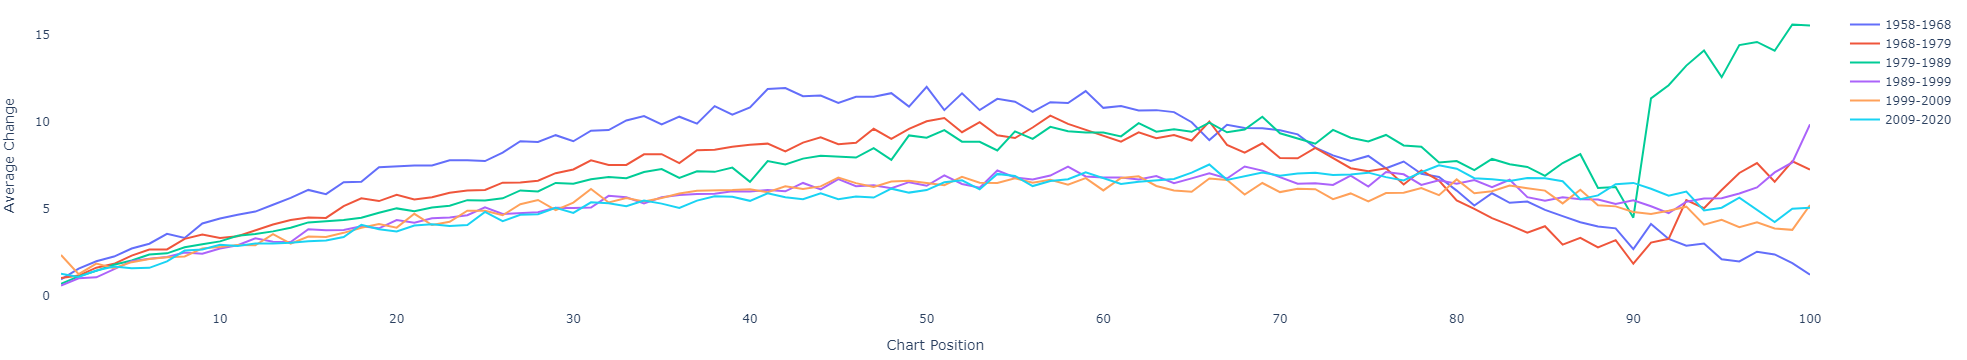

In [70]:
fig = go.Figure()
for i in range(0, len(change_df.columns), 535):
    fig.add_trace(go.Scatter(x=list(range(1, 101)),
                             y=abs(change_df.iloc[:, i:(i + 535)].replace('-', 0).fillna(0).astype('int')).mean(axis = 1),
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Chart Position",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

In [24]:
change_new_df = change_df.replace('-', 0).fillna(0).astype('int') + trend_df.apply(lambda x: [m*n for m,n in zip([y == 'New' for y in x], [100 - r for r in range(100)])])

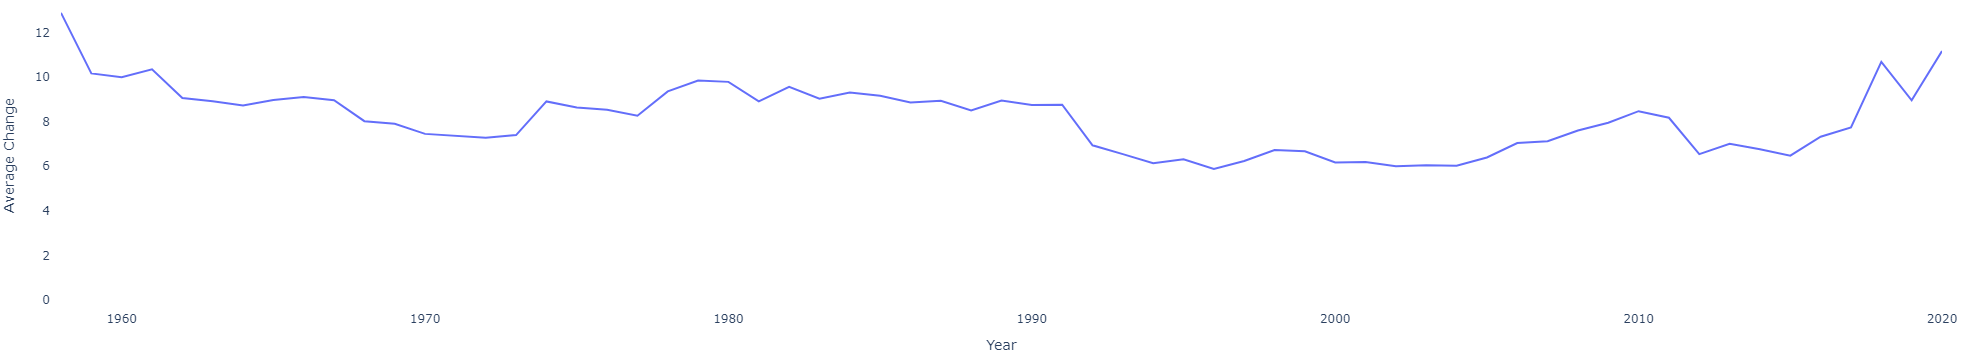

In [72]:
c1y_li = abs(change_new_df.loc[:, :].replace('-', 0).fillna(0).astype('int')).mean()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig = go.Figure(go.Scatter(x=c1y_li.index,
                           y=c1y_li,
                           mode='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 13])
fig.show()

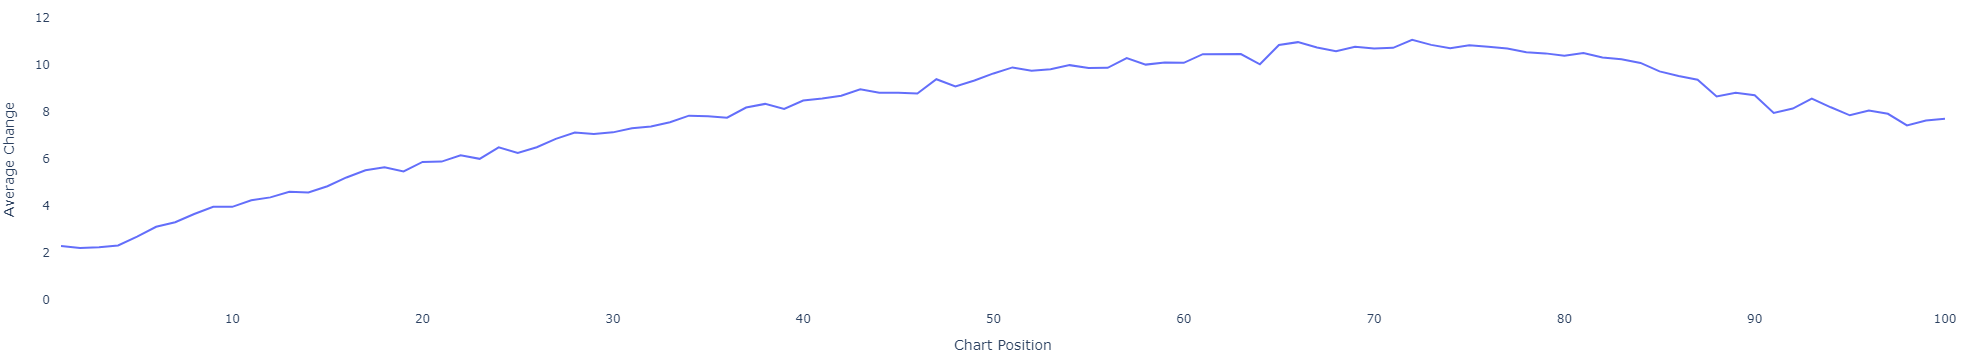

In [73]:
c1y_li = abs(change_new_df.loc[:, :].replace('-', 0).fillna(0).astype('int')).mean(axis = 1)
fig = go.Figure(go.Scatter(x=list(range(1, 101)),
                           y=c1y_li,
                           mode='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Chart Position",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 12])
fig.show()

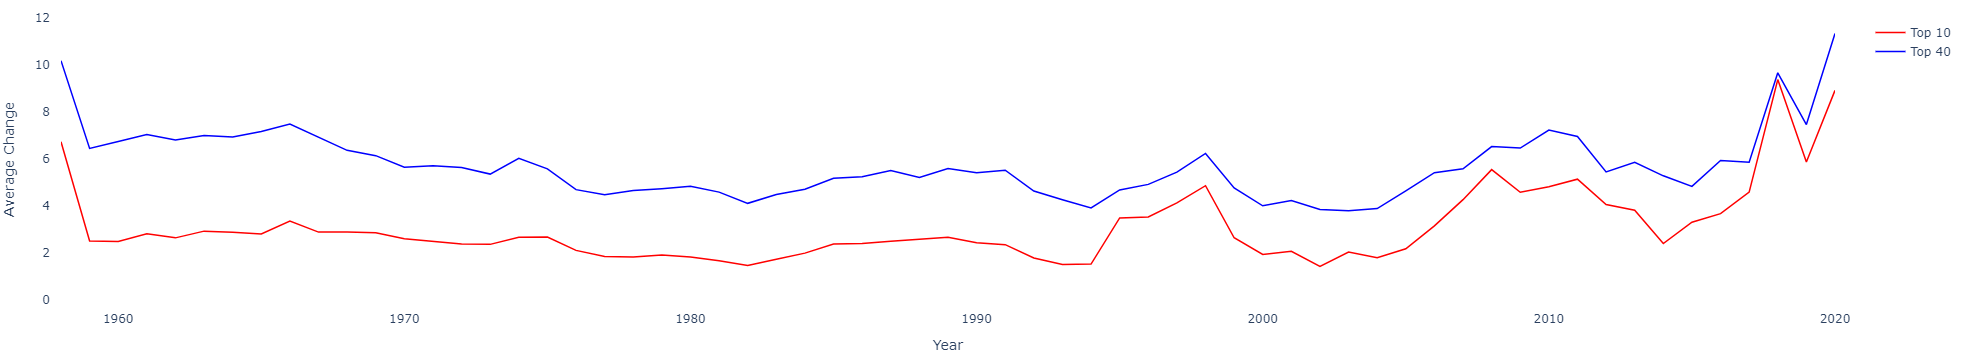

In [133]:
fig = go.Figure()

c1y_li = abs(change_new_df.loc[:9, :].replace('-', 0).fillna(0).astype('int')).mean()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color = 'red', width = 1.5),
                         name='Top 10'))

c1y_li = abs(change_new_df.loc[:39, :].replace('-', 0).fillna(0).astype('int')).mean()
c1y_li.index = [d[:4] for d in c1y_li.index]
c1y_li = c1y_li.groupby(level = 0).mean()
fig.add_trace(go.Scatter(x=c1y_li.index,
                         y=c1y_li,
                         line=dict(color = 'blue', width = 1.5),
                         name='Top 40'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 12])
fig.show()

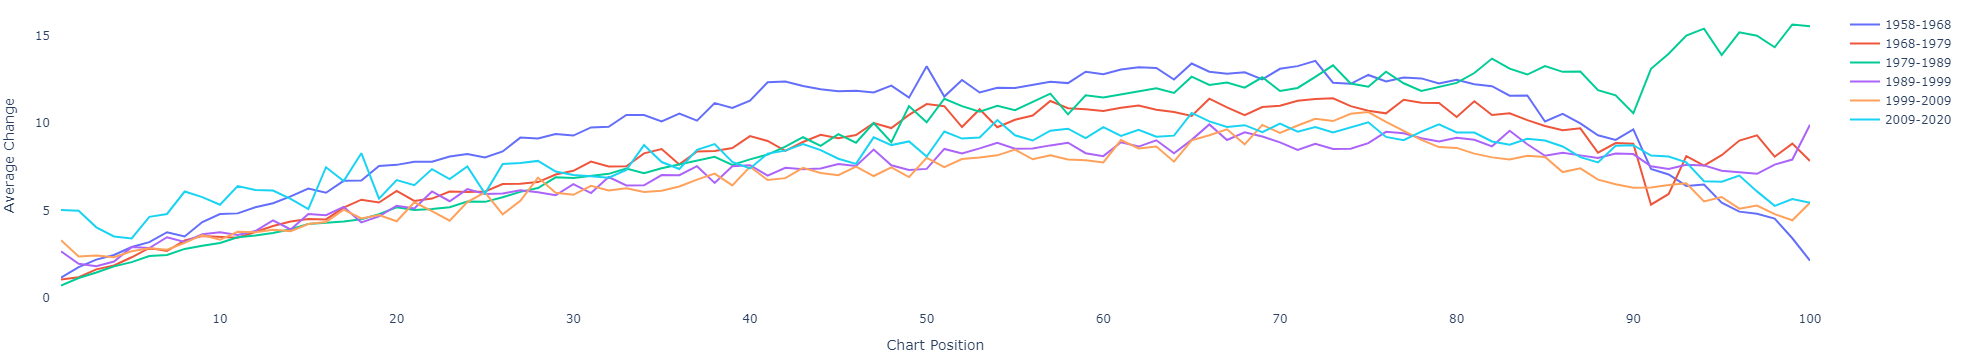

In [75]:
fig = go.Figure()
for i in range(0, len(change_new_df.columns), 535):
    fig.add_trace(go.Scatter(x=list(range(1, 101)),
                             y=abs(change_new_df.iloc[:, i:(i + 535)].replace('-', 0).fillna(0).astype('int')).mean(axis = 1),
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Chart Position",
                  yaxis_title="Average Change",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

## Part V: The Regulars in Chart

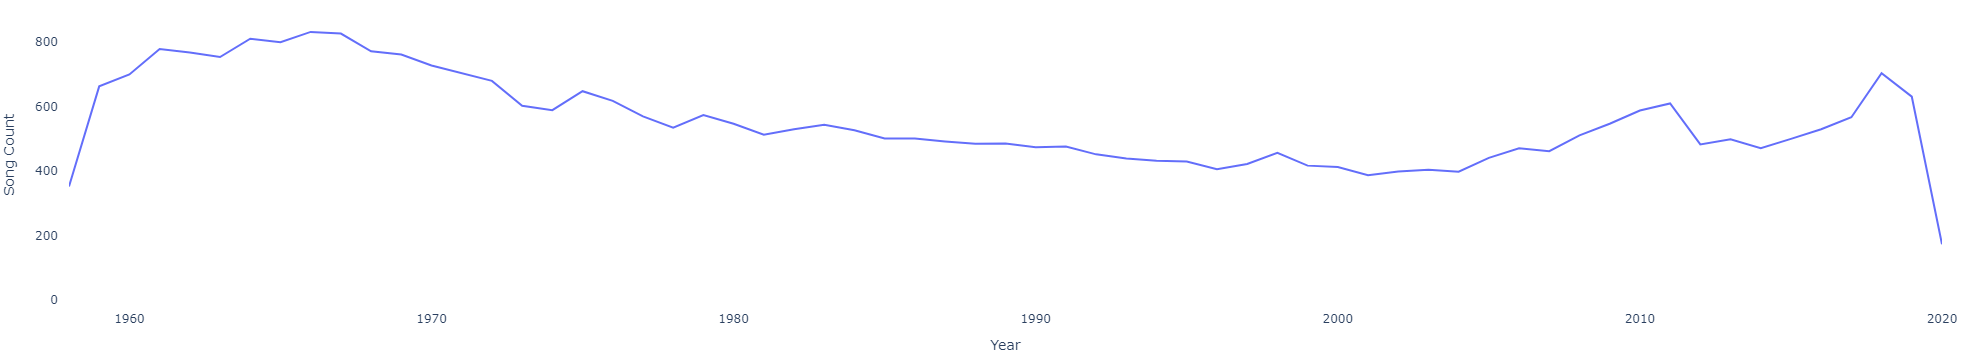

In [76]:
temp_title_df = title_df.copy().transpose()
temp_title_df['All'] = temp_title_df.apply(lambda x: [m for m in x.dropna()], axis=1)
temp_title_df.index = [t[:4] for t in temp_title_df.index]
temp_title_li = temp_title_df['All'].groupby(level = 0).apply(lambda x: len(set([l2 for l1 in x for l2 in l1])))

fig = go.Figure(go.Scatter(x=temp_title_li.index,
                           y=temp_title_li,
                           mode='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Song Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 900])
fig.show()

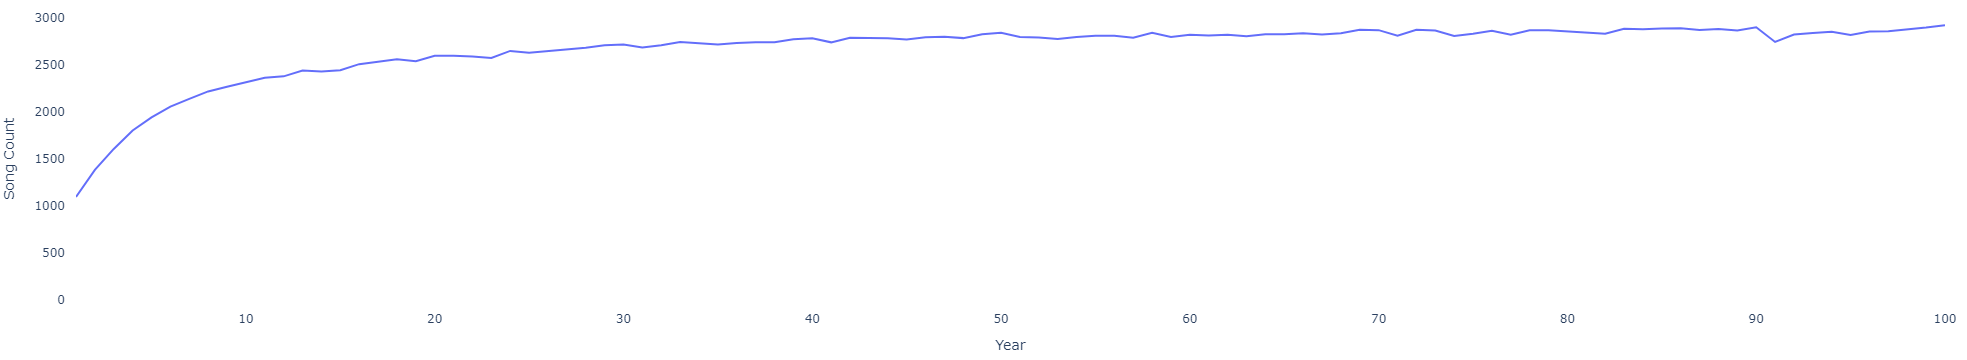

In [77]:
temp_title_df = title_df.copy()
temp_title_df['All'] = temp_title_df.apply(lambda x: [m for m in x.dropna()], axis=1)
temp_title_li = temp_title_df['All'].groupby(level = 0).apply(lambda x: len(set([l2 for l1 in x for l2 in l1])))

fig = go.Figure(go.Scatter(x=list(range(1, 101)),
                           y=temp_title_li,
                           mode='lines'))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Song Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 3000])
fig.show()

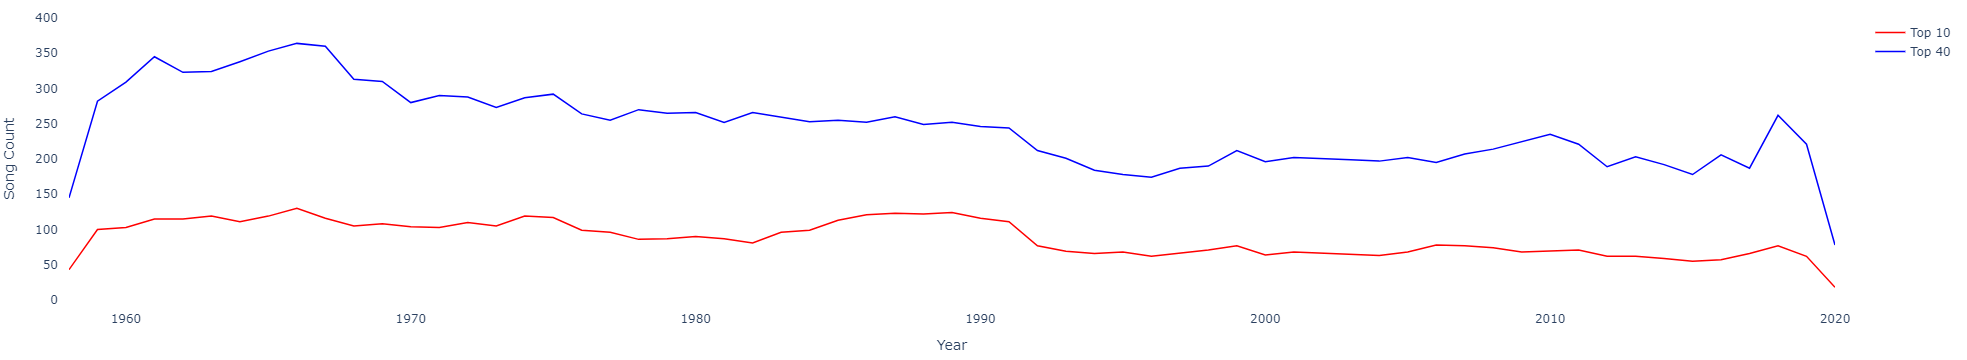

In [129]:
fig = go.Figure()
temp_title_df = title_df.loc[:9,:].copy().transpose()
temp_title_df['All'] = temp_title_df.apply(lambda x: [m for m in x.dropna()], axis=1)
temp_title_df.index = [t[:4] for t in temp_title_df.index]
temp_title_li = temp_title_df['All'].groupby(level = 0).apply(lambda x: len(set([l2 for l1 in x for l2 in l1])))
fig.add_trace(go.Scatter(x=temp_title_li.index,
                         y=temp_title_li,
                         line=dict(color='red', width=1.5),
                         name='Top 10'))

temp_title_df = title_df.loc[:39,:].copy().transpose()
temp_title_df['All'] = temp_title_df.apply(lambda x: [m for m in x.dropna()], axis=1)
temp_title_df.index = [t[:4] for t in temp_title_df.index]
temp_title_li = temp_title_df['All'].groupby(level = 0).apply(lambda x: len(set([l2 for l1 in x for l2 in l1])))
fig.add_trace(go.Scatter(x=temp_title_li.index,
                         y=temp_title_li,
                         line=dict(color='blue', width=1.5),
                         name='Top 40'))

fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Year",
                  yaxis_title="Song Count",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.update_yaxes(range=[0, 400])
fig.show()

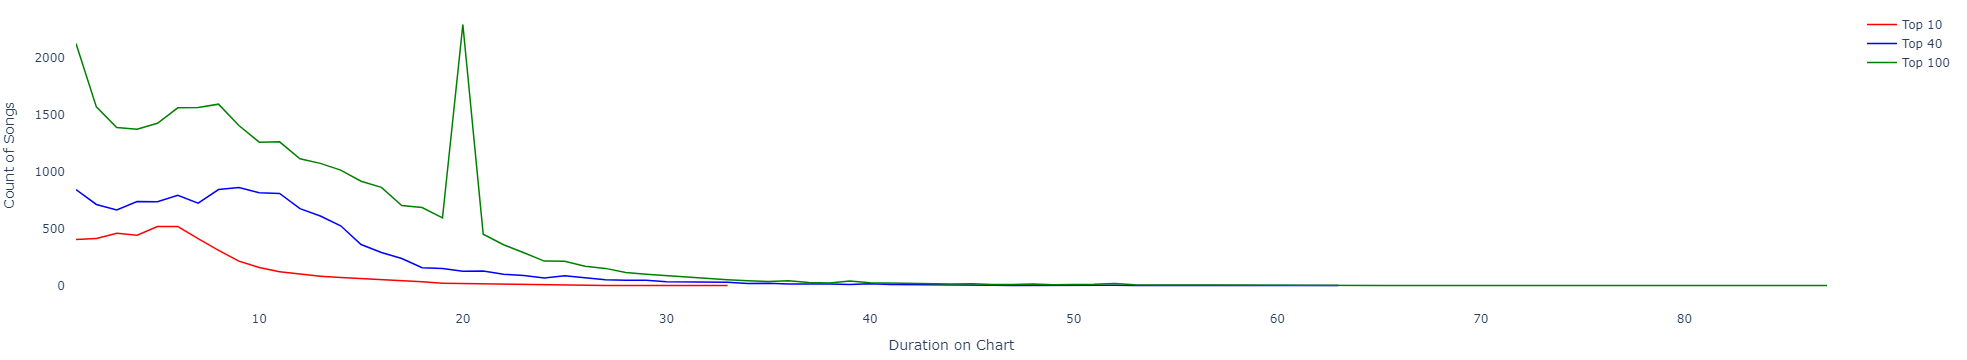

In [54]:
fig = go.Figure()

dct = Counter(Counter([l2 for l1 in title_df.iloc[0:9, :].values for l2 in l1]).values())
dct_x = list(dct.keys())
dct_x.sort()
fig.add_trace(go.Scatter(x=dct_x,
                         y=[dct.get(i) for i in dct_x],
                         line=dict(color='red', width=1.5),
                         name='Top 10'))

dct = Counter(Counter([l2 for l1 in title_df.iloc[0:39, :].values for l2 in l1]).values())
dct_x = list(dct.keys())
dct_x.sort()
fig.add_trace(go.Scatter(x=dct_x,
                         y=[dct.get(i) for i in dct_x],
                         line=dict(color='blue', width=1.5),
                         name='Top 40'))

dct = Counter(Counter([l2 for l1 in title_df.iloc[:, :].values for l2 in l1]).values())
dct_x = list(dct.keys())
dct_x.sort()
fig.add_trace(go.Scatter(x=dct_x,
                         y=[dct.get(i) for i in dct_x],
                         line=dict(color='green', width=1.5),
                         name='Top 100'))

fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Duration on Chart",
                  yaxis_title="Count of Songs",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

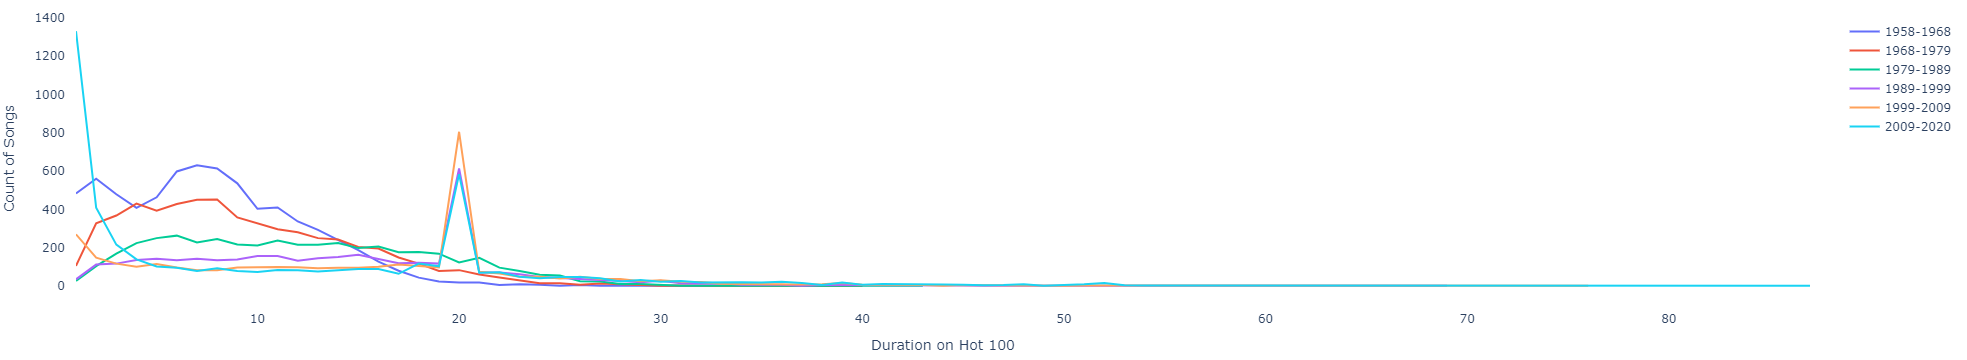

In [60]:
fig = go.Figure()
for i in range(0, len(title_df.columns), 535):
    dct = Counter(Counter([l2 for l1 in title_df.iloc[:, i:(i + 535)].values for l2 in l1]).values())
    dct_x = list(dct.keys())
    dct_x.sort()
    fig.add_trace(go.Scatter(x=dct_x,
                             y=[dct.get(i) for i in dct_x],
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Duration on Hot 100",
                  yaxis_title="Count of Songs",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

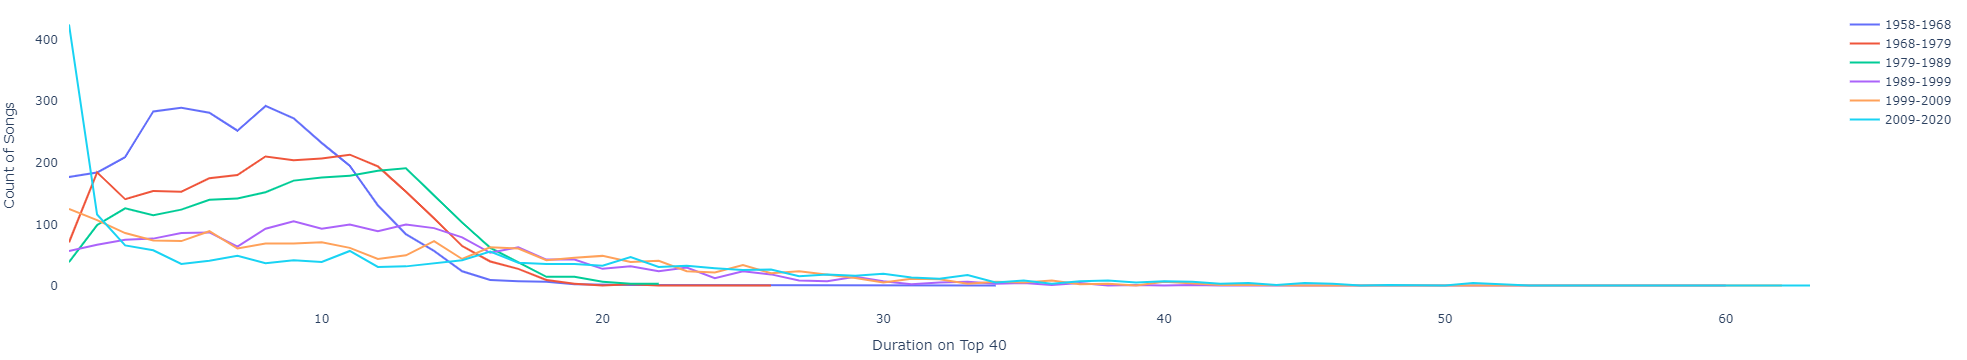

In [61]:
fig = go.Figure()
for i in range(0, len(title_df.columns), 535):
    dct = Counter(Counter([l2 for l1 in title_df.iloc[0:39, i:(i + 535)].values for l2 in l1]).values())
    dct_x = list(dct.keys())
    dct_x.sort()
    fig.add_trace(go.Scatter(x=dct_x,
                             y=[dct.get(i) for i in dct_x],
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Duration on Top 40",
                  yaxis_title="Count of Songs",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()

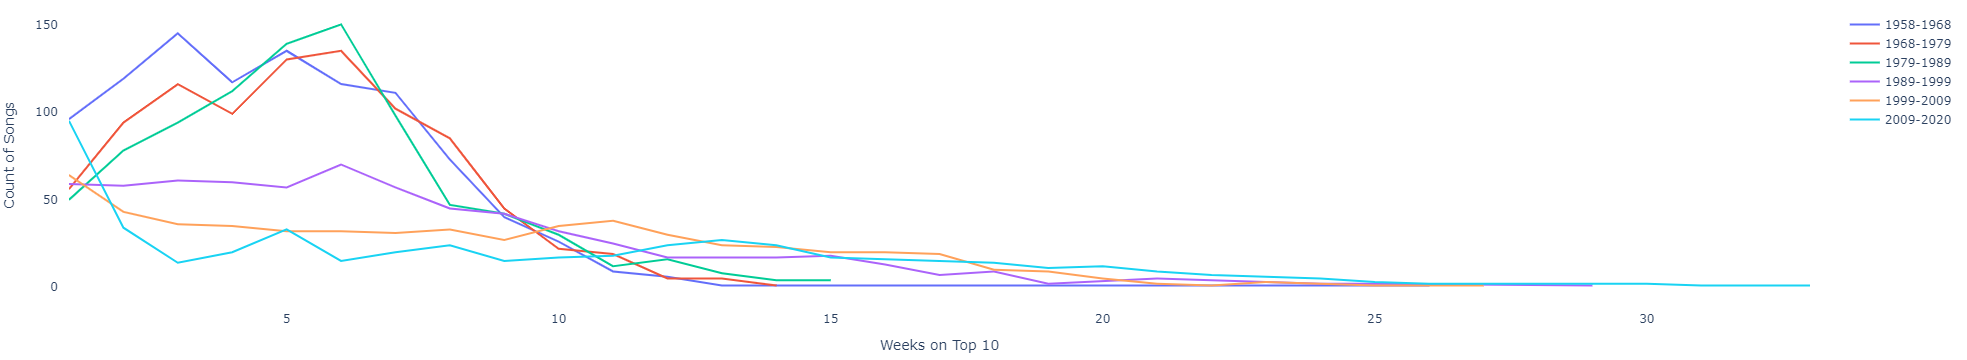

In [132]:
fig = go.Figure()
for i in range(0, len(title_df.columns), 535):
    dct = Counter(Counter([l2 for l1 in title_df.iloc[0:9, i:(i + 535)].values for l2 in l1]).values())
    dct_x = list(dct.keys())
    dct_x.sort()
    fig.add_trace(go.Scatter(x=dct_x,
                             y=[dct.get(i) for i in dct_x],
                             mode='lines',
                             name=chart_dates[i][:4]+'-'+chart_dates[i+534][:4]))
fig.update_layout(width=1000, 
                  height=350, 
                  plot_bgcolor='rgb(255,255,255)',
                  xaxis_title="Weeks on Top 10",
                  yaxis_title="Count of Songs",
                  margin={'l':10, 'r':10, 'b':10, 't':10, 'pad':10})
fig.show()